<a href="https://colab.research.google.com/github/probml/pyprobml/blob/master/notebooks/logreg_ucb_admissions_numpyro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Binomial logistic regression for UCB admissions

We illustrate binary logistic regression on 2 discrete inputs using the example in sec 11.1.4  of [Statistical Rethinking ed 2](https://xcelab.net/rm/statistical-rethinking/). 
The numpyro code is from [Du Phan's site](https://fehiepsi.github.io/rethinking-numpyro/11-god-spiked-the-integers.html)



In [1]:
!pip install -q numpyro@git+https://github.com/pyro-ppl/numpyro
!pip install -q arviz


In [4]:
import arviz as az
az.__version__


'0.11.2'

In [5]:
!pip install causalgraphicalmodels

In [ ]:
#!pip install -U daft

  Found existing installation: daft 0.0.4
    Uninstalling daft-0.0.4:
      Successfully uninstalled daft-0.0.4


In [6]:
import numpy as np
np.set_printoptions(precision=3)
import matplotlib.pyplot as plt
import math
import os
import warnings
import pandas as pd

import jax
print("jax version {}".format(jax.__version__))
print("jax backend {}".format(jax.lib.xla_bridge.get_backend().platform))

import jax.numpy as jnp
from jax import random, vmap
from jax.scipy.special import expit

rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

import numpyro
import numpyro.distributions as dist
from numpyro.distributions import constraints
from numpyro.distributions.transforms import AffineTransform
from numpyro.diagnostics import hpdi, print_summary
from numpyro.infer import Predictive
from numpyro.infer import MCMC, NUTS
from numpyro.infer import SVI, Trace_ELBO, init_to_value
from numpyro.infer.autoguide import AutoLaplaceApproximation
import numpyro.optim as optim


import daft
from causalgraphicalmodels import CausalGraphicalModel

from sklearn.preprocessing import StandardScaler

jax version 0.2.13
jax backend cpu


In [ ]:
n = jax.local_device_count()
print(n)

1


# Data

In [7]:

url = 'https://raw.githubusercontent.com/fehiepsi/rethinking-numpyro/master/data/UCBadmit.csv'
UCBadmit = pd.read_csv(url, sep=";")
d = UCBadmit
display(d)


,dept,applicant.gender,admit,reject,applications
1,A,male,512,313,825
2,A,female,89,19,108
3,B,male,353,207,560
4,B,female,17,8,25
5,C,male,120,205,325
6,C,female,202,391,593
7,D,male,138,279,417
8,D,female,131,244,375
9,E,male,53,138,191
10,E,female,94,299,393


In [ ]:
print(d.to_latex(index=False))

\begin{tabular}{llrrr}
\toprule
dept & applicant.gender &  admit &  reject &  applications \\
\midrule
   A &             male &    512 &     313 &           825 \\
   A &           female &     89 &      19 &           108 \\
   B &             male &    353 &     207 &           560 \\
   B &           female &     17 &       8 &            25 \\
   C &             male &    120 &     205 &           325 \\
   C &           female &    202 &     391 &           593 \\
   D &             male &    138 &     279 &           417 \\
   D &           female &    131 &     244 &           375 \\
   E &             male &     53 &     138 &           191 \\
   E &           female &     94 &     299 &           393 \\
   F &             male &     22 &     351 &           373 \\
   F &           female &     24 &     317 &           341 \\
\bottomrule
\end{tabular}



In [ ]:

dat_list = dict(
    admit=d.admit.values,
    applications=d.applications.values,
    gid=(d["applicant.gender"] != "male").astype(int).values,
)


print(dat_list)

{'admit': array([512,  89, 353,  17, 120, 202, 138, 131,  53,  94,  22,  24]), 'applications': array([825, 108, 560,  25, 325, 593, 417, 375, 191, 393, 373, 341]), 'gid': array([0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1])}


In [ ]:
# extract number of applicaitons for dept 2 (C)
d.applications[dat_list["dept_id"].copy() == 2]
               

5    325
6    593
Name: applications, dtype: int64

In [ ]:
d.applications[dat_list["dept_id"].copy() == 2].sum()

918

In [ ]:
# application rate per department
pg = jnp.stack(
    list(
        map(
            lambda k: jnp.divide(
                d.applications[dat_list["dept_id"].copy() == k].values,
                d.applications[dat_list["dept_id"].copy() == k].sum(),
            ),
            range(6),
        )
    ),
    axis=0,
).T
pg = pd.DataFrame(pg, index=["male", "female"], columns=d.dept.unique())
display(pg.round(2))
print(pg.to_latex())

,A,B,C,D,E,F
male,0.88,0.96,0.35,0.53,0.33,0.52
female,0.12,0.04,0.65,0.47,0.67,0.48


\begin{tabular}{lrrrrrr}
\toprule
{} &         A &         B &        C &         D &         E &         F \\
\midrule
male   &  0.884244 &  0.957265 &  0.35403 &  0.526515 &  0.327055 &  0.522409 \\
female &  0.115756 &  0.042735 &  0.64597 &  0.473485 &  0.672945 &  0.477591 \\
\bottomrule
\end{tabular}



In [ ]:
# admisions rate per department
pg = jnp.stack(
    list(
        map(
            lambda k: jnp.divide(
                d.admit[dat_list["dept_id"].copy() == k].values,
                d.applications[dat_list["dept_id"].copy() == k].values,
            ),
            range(6),
        )
    ),
    axis=0,
).T
pg = pd.DataFrame(pg, index=["male", "female"], columns=d.dept.unique())
display(pg.round(2))
print(pg.to_latex())

,A,B,C,D,E,F
male,0.62,0.63,0.37,0.33,0.28,0.06
female,0.82,0.68,0.34,0.35,0.24,0.07


\begin{tabular}{lrrrrrr}
\toprule
{} &         A &         B &         C &         D &         E &         F \\
\midrule
male   &  0.620606 &  0.630357 &  0.369231 &  0.330935 &  0.277487 &  0.058981 \\
female &  0.824074 &  0.680000 &  0.340641 &  0.349333 &  0.239186 &  0.070381 \\
\bottomrule
\end{tabular}



# Model 1

In [ ]:
dat_list = dict(
    admit=d.admit.values,
    applications=d.applications.values,
    gid=(d["applicant.gender"] != "male").astype(int).values,
)


def model(gid, applications, admit=None):
    a = numpyro.sample("a", dist.Normal(0, 1.5).expand([2]))
    logit_p = a[gid]
    numpyro.sample("admit", dist.Binomial(applications, logits=logit_p), obs=admit)


m11_7 = MCMC(NUTS(model), 500, 500, num_chains=4)
m11_7.run(random.PRNGKey(0), **dat_list)
m11_7.print_summary(0.89)

/usr/local/lib/python3.7/dist-packages/numpyro/infer/mcmc.py:269: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  self.num_chains, local_device_count(), self.num_chains
sample: 100%|██████████| 1000/1000 [00:01<00:00, 816.41it/s, 3 steps of size 8.87e-01. acc. prob=0.91]



                mean       std    median      5.5%     94.5%     n_eff     r_hat
      a[0]     -0.22      0.04     -0.22     -0.29     -0.16   2008.99      1.00
      a[1]     -0.83      0.05     -0.83     -0.91     -0.75   1810.07      1.00

Number of divergences: 0


In [ ]:
post = m11_7.get_samples()
diff_a = post["a"][:, 0] - post["a"][:, 1]
diff_p = expit(post["a"][:, 0]) - expit(post["a"][:, 1])
print_summary({"diff_a": diff_a, "diff_p": diff_p}, 0.89, False)


                mean       std    median      5.5%     94.5%     n_eff     r_hat
    diff_a      0.61      0.06      0.61      0.50      0.71   1926.84      1.00
    diff_p      0.14      0.01      0.14      0.12      0.16   1948.02      1.00



# Posterior predictive check

In [ ]:
def ppc(mcmc_run, model_args):
  post = mcmc_run.get_samples()
  pred = Predictive(mcmc_run.sampler.model, post)(random.PRNGKey(2), **model_args)
  admit_pred = pred["admit"]
  admit_rate = admit_pred / d.applications.values
  plt.errorbar(
      range(1, 13),
      jnp.mean(admit_rate, 0),
      jnp.std(admit_rate, 0) / 2,
      fmt="o",
      c="k",
      mfc="none",
      ms=7,
      elinewidth=1,
  )
  plt.plot(range(1, 13), jnp.percentile(admit_rate, 5.5, 0), "k+")
  plt.plot(range(1, 13), jnp.percentile(admit_rate, 94.5, 0), "k+")
  # draw lines connecting points from same dept
  for i in range(1, 7):
      x = 1 + 2 * (i - 1) # 1,3,5,7,9,11
      y1 = d.admit.iloc[x - 1] / d.applications.iloc[x - 1] # male
      y2 = d.admit.iloc[x] / d.applications.iloc[x] # female
      plt.plot((x, x + 1), (y1, y2), "bo-")
      plt.annotate(
          d.dept.iloc[x], (x + 0.5, (y1 + y2) / 2 + 0.05), ha="center", color="royalblue"
      )
  plt.gca().set(ylim=(0, 1), xticks=range(1, 13), ylabel="admit", xlabel="case")

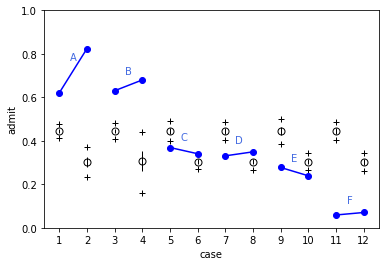

In [ ]:
ppc(m11_7, {'gid': dat_list["gid"], 'applications': dat_list["applications"]})
plt.savefig('admissions_ppc.pdf', dpi=300)
plt.show()

# Model 2 (departmental-specific offset)

In [ ]:


dat_list["dept_id"] = jnp.repeat(jnp.arange(6), 2)

def model(gid, dept_id, applications, admit=None):
    a = numpyro.sample("a", dist.Normal(0, 1.5).expand([2]))
    delta = numpyro.sample("delta", dist.Normal(0, 1.5).expand([6]))
    logit_p = a[gid] + delta[dept_id]
    numpyro.sample("admit", dist.Binomial(applications, logits=logit_p), obs=admit)


m11_8 = MCMC(NUTS(model), 2000, 2000, num_chains=4)
m11_8.run(random.PRNGKey(0), **dat_list)
m11_8.print_summary(0.89)

/usr/local/lib/python3.7/dist-packages/numpyro/infer/mcmc.py:269: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  self.num_chains, local_device_count(), self.num_chains
sample: 100%|██████████| 4000/4000 [00:05<00:00, 743.37it/s, 15 steps of size 6.43e-02. acc. prob=0.92]



                mean       std    median      5.5%     94.5%     n_eff     r_hat
      a[0]     -0.54      0.55     -0.54     -1.38      0.35    581.04      1.01
      a[1]     -0.44      0.55     -0.44     -1.31      0.42    579.82      1.01
  delta[0]      1.12      0.55      1.12      0.25      1.99    584.56      1.01
  delta[1]      1.08      0.55      1.07      0.20      1.95    589.21      1.01
  delta[2]     -0.14      0.55     -0.14     -1.02      0.73    583.25      1.01
  delta[3]     -0.17      0.55     -0.17     -1.03      0.72    588.07      1.01
  delta[4]     -0.62      0.55     -0.62     -1.50      0.25    584.70      1.01
  delta[5]     -2.17      0.57     -2.17     -3.12     -1.31    602.85      1.00

Number of divergences: 0


In [ ]:
post = m11_8.get_samples()
diff_a = post["a"][:, 0] - post["a"][:, 1]
diff_p = expit(post["a"][:, 0]) - expit(post["a"][:, 1])
print_summary({"diff_a": diff_a, "diff_p": diff_p}, 0.89, False)


                mean       std    median      5.5%     94.5%     n_eff     r_hat
    diff_a     -0.10      0.08     -0.10     -0.22      0.03   9440.98      1.00
    diff_p     -0.02      0.02     -0.02     -0.05      0.01   6953.82      1.00



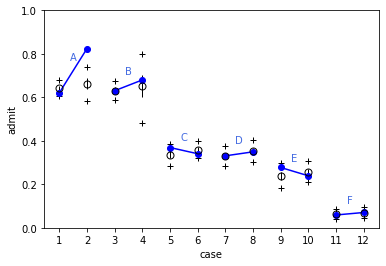

In [ ]:
data_dict = {'gid': dat_list["gid"],
             'dept_id': dat_list["dept_id"],
             'applications': dat_list["applications"]}
ppc(m11_8, data_dict)
#ppc(m11_8, dat_list) # must exclude 'admit' for predictive distribution
plt.savefig('admissions_ppc_per_dept.pdf', dpi=300)
plt.show()

In [ ]:
dat_list

{'admit': array([512,  89, 353,  17, 120, 202, 138, 131,  53,  94,  22,  24]),
 'applications': array([825, 108, 560,  25, 325, 593, 417, 375, 191, 393, 373, 341]),
 'dept_id': DeviceArray([0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5], dtype=int32),
 'gid': array([0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1])}

# Poisson regression

We now show we can emulate binomial regresison using 2 poisson regressions,
following sec 11.3.3 of rethinking. We use a simplified model that just predicts outcomes, and has no features (just an offset term).

In [24]:
# binomial model of overall admission probability
def model(applications, admit):
    a = numpyro.sample("a", dist.Normal(0, 1.5))
    logit_p = a
    numpyro.sample("admit", dist.Binomial(applications, logits=logit_p), obs=admit)

'''
m_binom = AutoLaplaceApproximation(model)
svi = SVI(
    model,
    m_binom,
    optim.Adam(1),
    Trace_ELBO(),
    applications=d.applications.values,
    admit=d.admit.values,
)
p_binom, losses = svi.run(random.PRNGKey(0), 1000)
'''

m_binom = MCMC(NUTS(model), 500, 500, num_chains=4)
m_binom.run(random.PRNGKey(0), d.applications.values, d.admit.values)
m_binom.print_summary(0.95)



100%|██████████| 1000/1000 [00:00<00:00, 1127.91it/s, init loss: 730.4814, avg. loss [951-1000]: 474.3684]
/usr/local/lib/python3.7/dist-packages/numpyro/infer/mcmc.py:269: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  self.num_chains, local_device_count(), self.num_chains
sample: 100%|██████████| 1000/1000 [00:00<00:00, 2991.75it/s, 1 steps of size 1.23e+00. acc. prob=0.92]


                mean       std    median      2.5%     97.5%     n_eff     r_hat
         a     -0.46      0.03     -0.46     -0.52     -0.39    800.65      1.01

Number of divergences: 0


In [20]:
logit = jnp.mean(m_binom.get_samples()["a"])
print(expit(logit))

0.38789943


In [17]:
def model(rej, admit):
    a1, a2 = numpyro.sample("a", dist.Normal(0, 1.5).expand([2]))
    lambda1 = jnp.exp(a1)
    lambda2 = jnp.exp(a2)
    numpyro.sample("rej", dist.Poisson(lambda2), obs=rej)
    numpyro.sample("admit", dist.Poisson(lambda1), obs=admit)


m_pois = MCMC(NUTS(model), 1000, 1000, num_chains=3)
m_pois.run(random.PRNGKey(0), d.reject.values, d.admit.values)
m_pois.print_summary(0.95)
                     


/usr/local/lib/python3.7/dist-packages/numpyro/infer/mcmc.py:269: UserWarning: There are not enough devices to run parallel chains: expected 3 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(3)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  self.num_chains, local_device_count(), self.num_chains
sample: 100%|██████████| 2000/2000 [00:00<00:00, 3192.13it/s, 1 steps of size 7.70e-01. acc. prob=0.93]



                mean       std    median      2.5%     97.5%     n_eff     r_hat
      a[0]      4.99      0.02      4.99      4.94      5.03   2334.86      1.00
      a[1]      5.44      0.02      5.44      5.40      5.48   3214.39      1.00

Number of divergences: 0


In [23]:
params = jnp.mean(m_pois.get_samples()["a"], 0)
a1 = params[0]
a2 = params[1]
lam1 = jnp.exp(a1)
lam2 = jnp.exp(a2)
print([lam1, lam2])
print(lam1 / (lam1 + lam2))

[DeviceArray(146.205, dtype=float32), DeviceArray(230.963, dtype=float32)]
0.3876396


# Beta-binomial regression

Sec 12.1.1 of rethinking.
Code from snippet 12.2 of [Du Phan's site](https://fehiepsi.github.io/rethinking-numpyro/12-monsters-and-mixtures.html)


In [36]:
d = UCBadmit
d["gid"] = (d["applicant.gender"] != "male").astype(int)
dat = dict(A=d.admit.values, N=d.applications.values, gid=d.gid.values)


def model(gid, N, A=None):
    a = numpyro.sample("a", dist.Normal(0, 1.5).expand([2]))
    phi = numpyro.sample("phi", dist.Exponential(1))
    theta = numpyro.deterministic("theta", phi + 2) # shape
    pbar = expit(a[gid]) # mean
    numpyro.sample("A", dist.BetaBinomial(pbar * theta, (1 - pbar) * theta, N), obs=A)


m12_1 = MCMC(NUTS(model), 500, 500, num_chains=4)
m12_1.run(random.PRNGKey(0), **dat)

/usr/local/lib/python3.7/dist-packages/numpyro/infer/mcmc.py:269: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  self.num_chains, local_device_count(), self.num_chains
sample: 100%|██████████| 1000/1000 [00:00<00:00, 2523.10it/s, 7 steps of size 5.29e-01. acc. prob=0.92]


In [37]:
post = m12_1.get_samples()
post["theta"] = Predictive(m12_1.sampler.model, post)(random.PRNGKey(1), **dat)["theta"]
post["da"] = post["a"][:, 0] - post["a"][:, 1]
print_summary(post, 0.89, False)


                mean       std    median      5.5%     94.5%     n_eff     r_hat
      a[0]     -0.45      0.43     -0.45     -1.13      0.23   1521.61      1.00
      a[1]     -0.33      0.40     -0.33     -0.95      0.30   1734.01      1.00
        da     -0.12      0.58     -0.11     -0.97      0.82   1731.04      1.00
       phi      1.03      0.81      0.87      0.00      2.04   1447.97      1.00
     theta      3.03      0.81      2.87      2.00      4.04   1447.97      1.00



In [39]:
post

{'a': DeviceArray([[ 0.006, -0.371],
              [-0.743, -0.347],
              [-0.104, -0.377],
              ...,
              [-0.976, -0.948],
              [ 0.453,  0.092],
              [-0.244,  0.167]], dtype=float32),
 'da': DeviceArray([ 0.376, -0.396,  0.272, ..., -0.028,  0.361, -0.412], dtype=float32),
 'phi': DeviceArray([0.962, 1.338, 2.239, ..., 3.375, 0.398, 0.241], dtype=float32),
 'theta': DeviceArray([2.962, 3.338, 4.239, ..., 5.375, 2.398, 2.241], dtype=float32)}

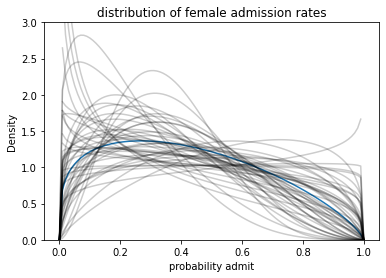

In [31]:
gid = 1
# draw posterior mean beta distribution
x = jnp.linspace(0, 1, 101)
pbar = jnp.mean(expit(post["a"][:, gid]))
theta = jnp.mean(post["theta"])
plt.plot(x, jnp.exp(dist.Beta(pbar * theta, (1 - pbar) * theta).log_prob(x)))
plt.gca().set(ylabel="Density", xlabel="probability admit", ylim=(0, 3))

# draw 50 beta distributions sampled from posterior
for i in range(50):
    p = expit(post["a"][i, gid])
    theta = post["theta"][i]
    plt.plot(
        x, jnp.exp(dist.Beta(p * theta, (1 - p) * theta).log_prob(x)), "k", alpha=0.2
    )
plt.title("distribution of female admission rates")
plt.savefig('admissions_betabinom_female_rate.pdf')
plt.show()

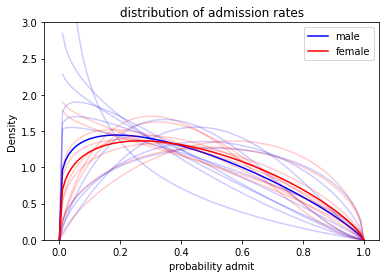

In [42]:
fig, ax = plt.subplots()
labels = ['male', 'female']
colors = ['b', 'r']
for gid in [0,1]:
  # draw posterior mean beta distribution
  x = jnp.linspace(0, 1, 101)
  pbar = jnp.mean(expit(post["a"][:, gid]))
  theta = jnp.mean(post["theta"])
  y = jnp.exp(dist.Beta(pbar * theta, (1 - pbar) * theta).log_prob(x))
  ax.plot(x, y, label=labels[gid], color=colors[gid])
  ax.set_ylabel("Density")
  ax.set_xlabel("probability admit")
  ax.set_ylim(0, 3)

  # draw some beta distributions sampled from posterior
  for i in range(10):
      p = expit(post["a"][i, gid])
      theta = post["theta"][i]
      y =jnp.exp(dist.Beta(p * theta, (1 - p) * theta).log_prob(x))
      plt.plot(x, y, colors[gid], alpha=0.2)

plt.title("distribution of admission rates")
plt.legend()
plt.savefig('admissions_betabinom_rates.pdf')
plt.show()

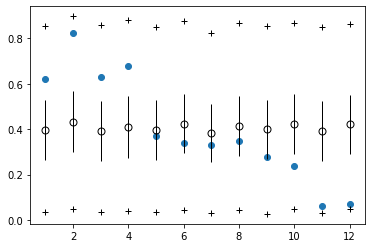

In [32]:
post = m12_1.get_samples()
admit_pred = Predictive(m12_1.sampler.model, post)(
    random.PRNGKey(1), gid=dat["gid"], N=dat["N"]
)["A"]
admit_rate = admit_pred / dat["N"]
plt.scatter(range(1, 13), dat["A"] / dat["N"])
plt.errorbar(
    range(1, 13),
    jnp.mean(admit_rate, 0),
    jnp.std(admit_rate, 0) / 2,
    fmt="o",
    c="k",
    mfc="none",
    ms=7,
    elinewidth=1,
)
plt.plot(range(1, 13), jnp.percentile(admit_rate, 5.5, 0), "k+")
plt.plot(range(1, 13), jnp.percentile(admit_rate, 94.5, 0), "k+")
plt.savefig('admissions_betabinom_post_pred.pdf')
plt.show()

# PGMs

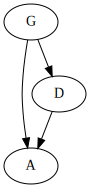

'admissions_dag.pdf'

In [ ]:

# p344
dag = CausalGraphicalModel(
    nodes=["G", "D", "A"], edges=[("G", "D"), ("G", "A"), ("D", "A")]
)
out = dag.draw()
display(out)  
out.render(filename='admissions_dag', format='pdf')

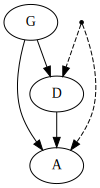

'admissions_dag_hidden.pdf'

In [ ]:
# p345
dag = CausalGraphicalModel(
    nodes=["G", "D", "A"],
    edges=[("G", "D"), ("G", "A"), ("D", "A")],
    latent_edges = [("D", "A")]
)
out = dag.draw()
display(out)  
out.render(filename='admissions_dag_hidden', format='pdf')

# Causal inference with  the latent DAG

This is based on sec 6.3 (collider bias) of the Rethinking book.
Code is from [Du Phan](https://fehiepsi.github.io/rethinking-numpyro/06-the-haunted-dag-and-the-causal-terror.html), code snippet 6.25. We change the names to match our current example: P (parents) -> D (department), C (child) -> A (admit).

## Linear regression version

In [ ]:
N = 200  # number of samples
b_GP = 1  # direct effect of G on P
b_GC = 0  # direct effect of G on C
b_PC = 1  # direct effect of P on C
b_U = 2  # direct effect of U on P and C

with numpyro.handlers.seed(rng_seed=1):
    U = 2 * numpyro.sample("U", dist.Bernoulli(0.5).expand([N])) - 1
    G = numpyro.sample("G", dist.Normal().expand([N]))
    P = numpyro.sample("P", dist.Normal(b_GP * G + b_U * U))
    C = numpyro.sample("C", dist.Normal(b_PC * P + b_GC * G + b_U * U))
    df_gauss = pd.DataFrame({"C": C, "P": P, "G": G, "U": U})

In [ ]:
def model_linreg(P, G, C):
    a = numpyro.sample("a", dist.Normal(0, 1))
    b_PC = numpyro.sample("b_PC", dist.Normal(0, 1))
    b_GC = numpyro.sample("b_GC", dist.Normal(0, 1))
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    mu = a + b_PC * P + b_GC * G
    numpyro.sample("C", dist.Normal(mu, sigma), obs=C)

data_gauss = {'P': df_gauss.P.values, 'G': df_gauss.G.values, 'C': df_gauss.C.values}

m6_11 = AutoLaplaceApproximation(model_linreg)
svi = SVI(model_linreg, m6_11, optim.Adam(0.3), Trace_ELBO(), **data_gauss)
p6_11, losses = svi.run(random.PRNGKey(0), 1000)
post = m6_11.sample_posterior(random.PRNGKey(1), p6_11, (1000,))
print_summary(post, 0.89, False)

mcmc_run = MCMC(NUTS(model_linreg), 200, 200, num_chains=4)
mcmc_run.run(random.PRNGKey(0), **data)
mcmc_run.print_summary(0.89)

100%|██████████| 1000/1000 [00:01<00:00, 558.33it/s, init loss: 4805.8169, avg. loss [951-1000]: 355.4688]
/usr/local/lib/python3.7/dist-packages/numpyro/infer/mcmc.py:269: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  self.num_chains, local_device_count(), self.num_chains
  0%|          | 0/400 [00:00<?, ?it/s]


                mean       std    median      5.5%     94.5%     n_eff     r_hat
         a     -0.08      0.10     -0.09     -0.24      0.06   1049.96      1.00
      b_GC     -0.71      0.11     -0.71     -0.89     -0.55    813.76      1.00
      b_PC      1.72      0.04      1.72      1.65      1.79    982.64      1.00
     sigma      1.39      0.07      1.39      1.28      1.49    968.54      1.00



sample: 100%|██████████| 400/400 [00:00<00:00, 685.82it/s, 7 steps of size 7.86e-01. acc. prob=0.91]



                mean       std    median      5.5%     94.5%     n_eff     r_hat
         a     -0.08      0.10     -0.08     -0.24      0.07    913.17      1.00
      b_GC     -0.71      0.10     -0.71     -0.87     -0.55    664.31      1.00
      b_PC      1.72      0.04      1.72      1.65      1.79    707.30      1.00
     sigma      1.40      0.07      1.40      1.30      1.51    799.91      1.00

Number of divergences: 0


In [ ]:
def model_linreg_hidden(P, G, U, C):
    a = numpyro.sample("a", dist.Normal(0, 1))
    b_PC = numpyro.sample("b_PC", dist.Normal(0, 1))
    b_GC = numpyro.sample("b_GC", dist.Normal(0, 1))
    b_U = numpyro.sample("U", dist.Normal(0, 1))
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    mu = a + b_PC * P + b_GC * G + b_U * U
    numpyro.sample("C", dist.Normal(mu, sigma), obs=C)


m6_12 = AutoLaplaceApproximation(model_linreg_hidden)
svi = SVI(
    model_linreg_hidden,
    m6_12,
    optim.Adam(1),
    Trace_ELBO(),
    P=d.P.values,
    G=d.G.values,
    U=d.U.values,
    C=d.C.values,
)
p6_12, losses = svi.run(random.PRNGKey(0), 1000)
post = m6_12.sample_posterior(random.PRNGKey(1), p6_12, (1000,))
print_summary(post, 0.89, False)

100%|██████████| 1000/1000 [00:02<00:00, 479.99it/s, init loss: 565.4859, avg. loss [951-1000]: 307.1190]



                mean       std    median      5.5%     94.5%     n_eff     r_hat
         U      1.87      0.17      1.88      1.59      2.11   1009.20      1.00
         a     -0.06      0.08     -0.05     -0.18      0.07    766.03      1.00
      b_GC      0.01      0.10      0.01     -0.15      0.17   1031.98      1.00
      b_PC      0.99      0.07      0.99      0.88      1.11   1106.62      1.00
     sigma      1.08      0.05      1.08      0.99      1.16    797.58      1.00



## Logistic regression version

We modify the scenario to match the UC Berkeley admissions scenario (with binary data) in sec 11.1.4.

In [ ]:
N = 200  # number of samples
b_GP = 1  # direct effect of G on P
b_GC = 0  # direct effect of G on C
b_PC = 1  # direct effect of P on C
b_U = 2  # direct effect of U on P and C

with numpyro.handlers.seed(rng_seed=1):
    #U = 2 * numpyro.sample("U", dist.Bernoulli(0.5).expand([N])) - 1
    U = numpyro.sample("U", dist.Normal().expand([N]))
    #G = numpyro.sample("G", dist.Normal().expand([N]))
    G = numpyro.sample("G", dist.Bernoulli(0.5).expand([N])) 
    P = numpyro.sample("P", dist.Normal(b_GP * G + b_U * U))
    #C = numpyro.sample("C", dist.Normal(b_PC * P + b_GC * G + b_U * U))
    logits = b_PC * P + b_GC * G + b_U * U
    probs = expit(logits)
    C = numpyro.sample("C", dist.BernoulliProbs(probs))
    df_binary = pd.DataFrame({"C": C, "G": G, "P": P,  "U": U, "probs": probs})

display(df_binary.head(10))

,C,P,G,U,probs
0,1,2.760981,0,0.921780,0.990093
1,1,-0.477833,0,-0.646999,0.145315
2,0,-1.092095,-1,-1.108740,0.035244
3,0,-3.478733,0,-1.700618,0.001027
4,1,-0.999583,0,-0.570333,0.105246
5,1,-0.972953,-1,0.398886,0.456317
6,0,-0.821708,0,-0.773144,0.085646
7,1,3.061834,-1,1.711392,0.998476
8,1,4.175874,0,1.578928,0.999347
9,0,-0.802110,0,-0.601525,0.118662


In [ ]:
def model_causal(C=None, G=None, P=None, U=None):
    U = numpyro.sample("U", dist.Normal(), obs=U)
    G = numpyro.sample("G", dist.Bernoulli(0.5), obs=G)
    P = numpyro.sample("P", dist.Normal(b_GP * G + b_U * U), obs=P) 
    logits = b_PC * P + b_GC * G + b_U * U
    probs = expit(logits)
    C = numpyro.sample("C", dist.BernoulliProbs(probs), obs=C)
    return np.array([C, G, P, U])


,C,G,P,U
0,0.0,1.0,-1.016595,-1.251539
1,0.0,0.0,-0.258828,-0.648633
2,0.0,1.0,-2.297220,-0.604780
3,1.0,1.0,5.914941,2.049074
4,1.0,0.0,4.471634,2.095908


In [ ]:
def make_samples(C=None, G=None, P=None, U=None, nsamples=200):
  data_list = []
  with numpyro.handlers.seed(rng_seed=0):
    for i in range(nsamples):
      out = model_causal(C, G, P, U)
      data_list.append(out)
  df = pd.DataFrame.from_records(data_list, columns=['C','G','P','U'])
  return df

df_binary = make_samples() 
display(df_binary.head())



,C,G,P,U
0,0.0,1.0,-1.016595,-1.251539
1,0.0,0.0,-0.258828,-0.648633
2,0.0,1.0,-2.297220,-0.604780
3,1.0,1.0,5.914941,2.049074
4,1.0,0.0,4.471634,2.095908


In [ ]:

Cbar = df_binary['C'].values.mean()
Gbar = df_binary['G'].values.mean()
Pbar = df_binary['P'].values.mean()
Ubar = df_binary['U'].values.mean()
print([Cbar, Gbar, Pbar, Ubar])
print(b_GP * Gbar + b_U * Ubar) # expected Pbar



[0.65, 0.465, 0.9102400523796678, 0.15905934125650675]
0.7831186825130135


In [ ]:
N = len(df0)
prob_admitted0 = np.sum(df0.C.values)/N
prob_admitted1 = np.sum(df1.C.values)/N
print([prob_admitted0, prob_admitted1])

[0.5, 0.59]


In [ ]:
def model_logreg(C=None, G=None, P=None):
    a = numpyro.sample("a", dist.Normal(0, 1))
    b_PC = numpyro.sample("b_PC", dist.Normal(0, 0.1))
    b_GC = numpyro.sample("b_GC", dist.Normal(0, 0.1))
    logits = a + b_PC * P + b_GC * G
    numpyro.sample("C", dist.Bernoulli(logits=logits), obs=C)

data_binary = {'P': df_binary.P.values, 'G': df_binary.G.values, 'C': df_binary.C.values}

warmup  = 1000
samples = 500
mcmc_run = MCMC(NUTS(model_logreg), warmup, samples, num_chains=4)
mcmc_run.run(random.PRNGKey(0), **data)
mcmc_run.print_summary(0.89)

/usr/local/lib/python3.7/dist-packages/numpyro/infer/mcmc.py:269: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  self.num_chains, local_device_count(), self.num_chains
sample: 100%|██████████| 1500/1500 [00:02<00:00, 670.65it/s, 3 steps of size 8.32e-01. acc. prob=0.90]


                mean       std    median      5.5%     94.5%     n_eff     r_hat
         a    -22.18      0.70    -22.17    -23.33    -21.08   2259.97      1.00
      b_GC      2.09      0.10      2.09      1.94      2.25   1966.21      1.00
      b_PC     18.12      0.10     18.12     17.96     18.29   2010.51      1.00

Number of divergences: 0


## Counterfactual plot

Similar to p140

In [ ]:
# p(C | do(G), do(P))
Pfixed = 0

df0 = make_samples(G=0, P=Pfixed, nsamples=200) 
display(df0.head())
Cbar0 = df0['C'].values.mean()

df1 = make_samples(G=1, P=Pfixed, nsamples=200) 
display(df1.head())
Cbar1 = df1['C'].values.mean()

print([Cbar0, Cbar1])

,C,G,P,U
0,0.0,0.0,0.0,-1.251539
1,1.0,0.0,0.0,0.486483
2,0.0,0.0,0.0,-0.648633
3,1.0,0.0,0.0,1.038439
4,1.0,0.0,0.0,-0.604780


,C,G,P,U
0,0.0,1.0,0.0,-1.251539
1,1.0,1.0,0.0,0.486483
2,0.0,1.0,0.0,-0.648633
3,1.0,1.0,0.0,1.038439
4,1.0,1.0,0.0,-0.604780


[0.565, 0.565]


In [ ]:
sim_dat = dict(G=jnp.array([0,1]), P=jnp.array(Pfixed))
post = mcmc_run.get_samples()
pred = Predictive(model_logreg, post)(random.PRNGKey(22), **sim_dat)
print(pred['C'].shape)
print(np.mean(pred['C'], axis=0))


(2000, 2)
[0.000 0.000]


In [ ]:
a_est = post['a'].mean()
b_PC_est = post['b_PC'].mean()
b_GC_est = post['b_GC'].mean()
P = Pfixed

G = np.array([0,1])
logits = a_est + b_PC_est * P + b_GC_est * G
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
print(expit(logits))

[0.000 0.000]


In [ ]:
pred

{'C': DeviceArray([[0, 1],
              [0, 1],
              [0, 1],
              ...,
              [0, 1],
              [0, 1],
              [0, 1]], dtype=int32)}